In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
import random

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## -----mac OS系统中文&正负号显示-----
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
import sys
%load_ext autoreload
%autoreload 2
sys.path.append("../src")
from regression_lgbmodel import LgbRegression
from feature_engineering import feat_engineering, city_preprocess, data_day_group, data_merge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_power = pd.read_csv('../../../初赛1008/训练集/power.csv')
df_his = pd.read_csv('../../../初赛1008/训练集/power_forecast_history.csv')
df_stub = pd.read_csv('../../../初赛1008/训练集/stub_info.csv')

df_test_his = pd.read_csv('../../../初赛1008/测试集/power_forecast_history.csv')
df_test_stub = pd.read_csv('../../../初赛1008/测试集/stub_info.csv')
df_stub.equals(df_test_stub)

df_his_all = pd.concat([df_his, df_test_his]).reset_index(drop=True)
df_his_all.head()

True

id_encode  hour  ele_price  ser_price  after_ser_price  total_price   f1  \
0          0   0.0       0.64       0.95             0.31         1.59  0.0   
1          0   1.0       0.64       0.95             0.31         1.59  0.0   
2          0   2.0       0.64       0.95             0.31         1.59  0.0   
3          0   3.0       0.64       0.95             0.31         1.59  0.0   
4          0   4.0       0.64       0.95             0.31         1.59  0.0   

    f2   f3        ds  
0  0.0  1.0  20220415  
1  0.0  1.0  20220415  
2  0.0  1.0  20220415  
3  0.0  1.0  20220415  
4  0.0  1.0  20220415

In [4]:
# 每小时内的变化比较小
df_tmp = df_his.groupby(['id_encode','ds']).agg('nunique').reset_index()
df_tmp.max()


id_encode               499
ds                 20230414
hour                     24
ele_price                 4
ser_price                 4
after_ser_price           4
total_price               4
f1                        3
f2                        4
f3                        1
dtype: int64

In [16]:
df_city = pd.read_csv('../data/初赛1008/h3_feature.csv',encoding='GBK')
df_weather = pd.read_parquet('../data/初赛1008/city_weather.parquet')

df_city = city_preprocess(df_city, df_weather)


In [8]:
df_his_day, df_power_day, df_power_mean = data_day_group(df_his_all, df_power)
df = data_merge(df_stub, df_his_day, df_power_day, df_power_mean, df_city)
df = feat_engineering(df)

df = df.merge(df_city, on=['h3', 'time'], how='left')
# 删除填补的空缺字段
df = df_his_day[['id_encode','ds']].merge(df, on=['id_encode','ds'], how='left')
df.shape

df_train = df[df['ds']<20230415]
df_train = df_train[(~df_train['power_sum'].isnull())]
# 删除部分20230101空数据
df_train = df_train[df_train[['ele_price_mean', 'ser_price_mean']].isnull().sum(axis=1) == 0]
# 时间截断
df_train = df_train[~df_train['power_1week'].isnull()]
df_test = df[df['ds']>=20230415]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train.shape, df_test.shape

df_time_all.shape: (186000, 4)
ori df: (186000, 29)
feat df: (186000, 55)


(152544, 62)

((145078, 62), (3500, 62))

In [17]:
df_city_label = df[['h3', 'time', 'power_sum','id_encode','ds']].merge(df_city, on=['h3', 'time'], how='left')
df_city_label.shape
df_city_label = df_city_label[~df_city_label['power_sum'].isnull()]
df_city_label.shape

(152544, 13)

(149044, 13)

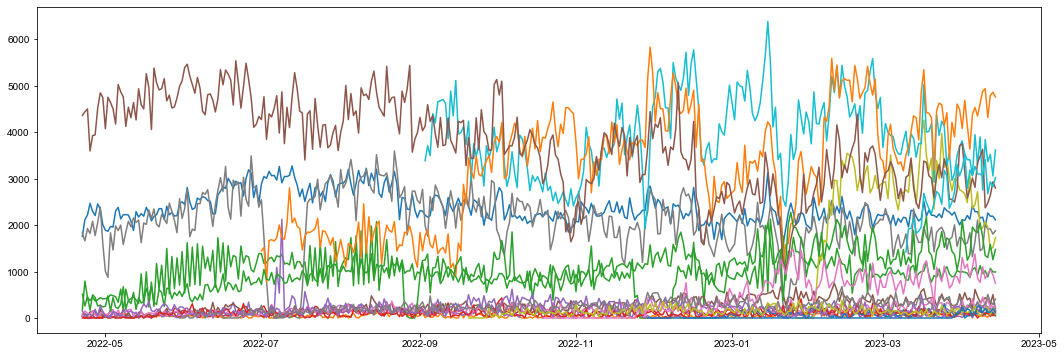

In [148]:
# df_tmp = df_train[df_train['id_encode']==1]
import matplotlib.pyplot as plt
plt.figure(figsize=[18, 6])
i = 0
for ds, df_group in df_train.groupby('id_encode'):
    plt.plot(df_group['time'], df_group['power_sum']);
    i += 1
    if i > 20:
        break
plt.show();

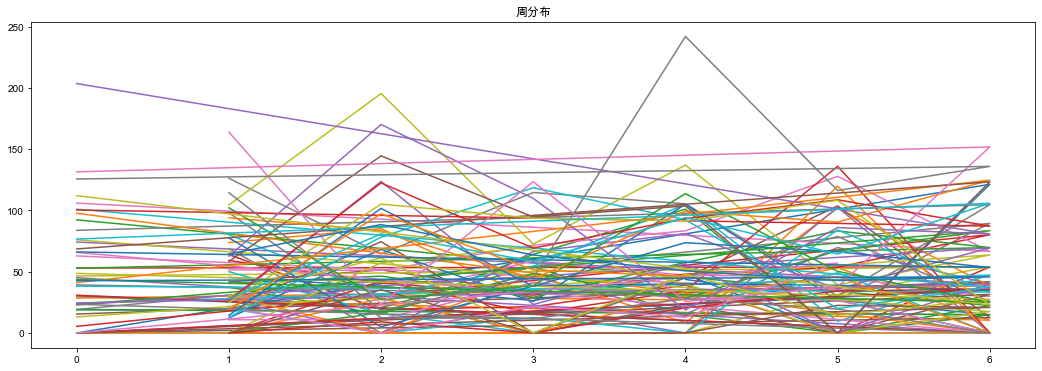

In [21]:
df_tmp = df_train[df_train['id_encode']==1]

plt.figure(figsize=[18, 6])
i = 0
for ds, df_group in df_tmp.groupby('weeks'):
    plt.plot(df_group['day_of_week'], df_group['power_sum']);
    i += 1
    if i > 100:
        break
plt.title('周分布')
plt.show();

In [40]:
cols_mean = [x for x in df.columns if 'std' in x]
cols_mean += ['power_1week', 'power_sum']
cols_mean

['ele_price_std',
 'ser_price_std',
 'after_ser_price_std',
 'total_price_std',
 'f1_std',
 'f2_std',
 'power_std',
 'power_roll7_7ago_std',
 'power_roll14_14ago_std',
 'power_roll21_21ago_std',
 'power_roll30_30ago_std',
 'power_sum_std_2week',
 'power_sum_std_month_num_2',
 'power_1week',
 'power_sum']

In [ ]:
def corr_plot(df, cols):
    R = df[cols].corr()
    mask = np.array(R)
    mask[np.tril_indices_from(mask)] = False  # 下三角
    plt.figure(figsize=[14, 10])
    sns.heatmap(R, linewidth=0.1, vmax=0.8,
                cmap='Oranges',  # Blues
                annot=True,  # 是否显示数字
                # annot_kws={'fontsize':10,'fontweight':'bold'},  # 数字大小、字体
                mask=mask,  # 隐藏上半三角
                )

## 天气分析

In [35]:
df_city['weather'].value_counts().head(20)

#.head(20)

多云       33411
晴         9866
雾         6137
阴         4498
小雨        4157
多云~阴      2411
阴~多云      1564
多云~晴      1383
多云~小雨     1183
晴~多云      1021
雾~多云       992
阴~晴        923
中雨         865
小雨~多云      798
小雨到中雨      780
多云~中雨      575
小雨~阴       572
雾~阴        386
阴~小雨       373
中雨~多云      332
Name: weather, dtype: int64

In [29]:
df_city1_1.tail(20)

h3       time  power_sum  id_encode        ds   longitude  \
37051  8530981bfffffff 2023-02-09  3431.0411        121  20230209  120.602388   
37053  8530981bfffffff 2023-02-11  3817.0909        121  20230211  120.602388   
37054  8530981bfffffff 2023-02-12  3360.6951        121  20230212  120.602388   
37055  8530981bfffffff 2023-02-13  3765.0418        121  20230213  120.602388   
37065  8530981bfffffff 2023-02-23  3536.9009        121  20230223  120.602388   
37081  8530981bfffffff 2023-03-11  2961.8490        121  20230311  120.602388   
37086  8530981bfffffff 2023-03-16  3008.5418        121  20230316  120.602388   
37087  8530981bfffffff 2023-03-17  3389.1951        121  20230317  120.602388   
37090  8530981bfffffff 2023-03-20  2819.8210        121  20230320  120.602388   
37091  8530981bfffffff 2023-03-21  2010.5101        121  20230321  120.602388   
37092  8530981bfffffff 2023-03-22  2432.0018        121  20230322  120.602388   
37093  8530981bfffffff 2023-03-23  2639.8402        121  20230323  120.602388   
37094  8530981bfffffff 2023-03-24  3609.2832        121  20230324  120.602388   
37099  8530981bfffffff 2023-03-29  3576.0730        121  20230329  120.602388   
37100  8530981bfffffff 2023-03-30  2814.6801        121  20230330  120.602388   
37104  8530981bfffffff 2023-04-03  2961.3429        121  20230403  120.602388   
37105  8530981bfffffff 2023-04-04  2807.3691        121  20230404  120.602388   
37106  8530981bfffffff 2023-04-05  2687.7822        121  20230405  120.602388   
37107  8530981bfffffff 2023-04-06  3367.6337        121  20230406  120.602388   
37114  8530981bfffffff 2023-04-13  2797.1258        121  20230413  120.602388   

       latitude city  temp_max  temp_min weather  temp_mean  temp_diff  
37051  31.29903  苏州市       6.0       3.0      中雨        4.5        3.0  
37053  31.29903  苏州市       7.0       6.0      小雨        6.5        1.0  
37054  31.29903  苏州市       9.0       2.0      小雨        5.5        7.0  
37055  31.29903  苏州市       5.0      -1.0     雨夹雪        2.0        6.0  
37065  31.29903  苏州市       6.0       1.0      小雨        3.5        5.0  
37081  31.29903  苏州市      24.0       9.0   多云~小雨       16.5       15.0  
37086  31.29903  苏州市      14.0       8.0   多云~中雨       11.0        6.0  
37087  31.29903  苏州市       7.0       5.0   中雨~多云        6.0        2.0  
37090  31.29903  苏州市      13.0      12.0   多云~大雨       12.5        1.0  
37091  31.29903  苏州市      14.0      13.0    雾~小雨       13.5        1.0  
37092  31.29903  苏州市      15.0      12.0    雾~小雨       13.5        3.0  
37093  31.29903  苏州市      12.0       8.0    小雨~阴       10.0        4.0  
37094  31.29903  苏州市      10.0       5.0   小雨~多云        7.5        5.0  
37099  31.29903  苏州市      17.0      11.0   多云~小雨       14.0        6.0  
37100  31.29903  苏州市      14.0      10.0    小雨~阴       12.0        4.0  
37104  31.29903  苏州市      18.0      16.0   小雨~大雨       17.0        2.0  
37105  31.29903  苏州市      22.0      13.0      小雨       17.5        9.0  
37106  31.29903  苏州市      13.0       9.0   多云~小雨       11.0        4.0  
37107  31.29903  苏州市      13.0      10.0   小雨~多云       11.5        3.0  
37114  31.29903  苏州市      20.0      17.0  多云~雷阵雨       18.5        3.0

In [30]:
df_city1['weather'].value_counts()

df_city1_1 = df_city1[df_city1['weather'].apply(lambda x: '雨' in x)]

多云        190
雾          48
晴          36
小雨         30
阴          21
小雨到中雨       5
中雨          4
多云~小雨       3
暴雨          2
小雨~多云       2
小雨~阴        2
雾~小雨        2
多云~晴        2
雨夹雪         2
小雨到大雨       2
多云转阴        2
小雨到暴雨       1
晴转多云        1
晴~多云        1
多云~中雨       1
中雨~多云       1
雾~阴         1
多云~大雨       1
阴到中雨        1
阴到小雨        1
小雨~大雨       1
雾~多云        1
多云~雷阵雨      1
Name: weather, dtype: int64

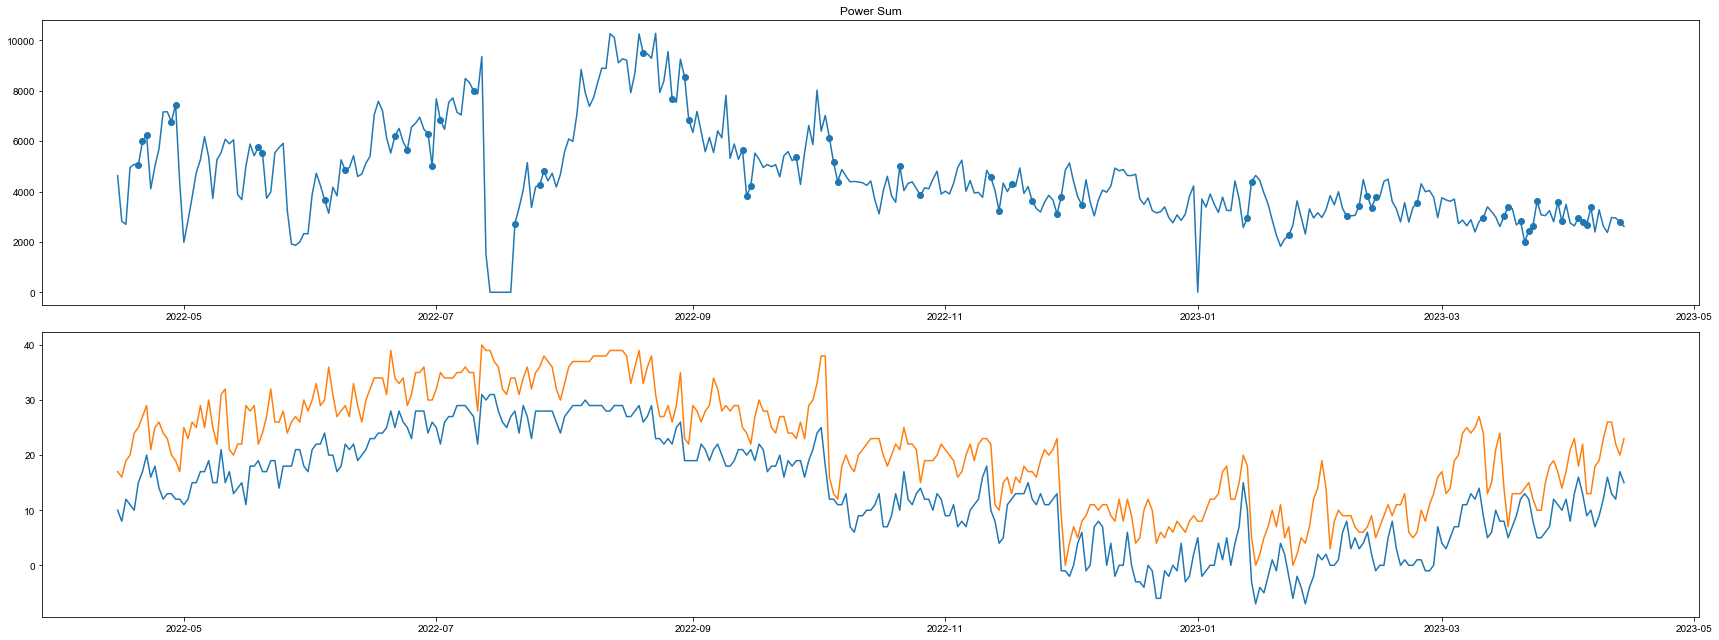

In [26]:
df_city1 = df_city_label[df_city_label['id_encode']==121]
fig, axes = plt.subplots(2, 1, figsize=(24, 9))

axes[0].plot(df_city1['time'], df_city1['power_sum'])
axes[0].scatter(df_city1_1['time'], df_city1_1['power_sum'])

axes[0].set_title('Power Sum')

axes[1].plot(df_city1['time'], df_city1['temp_min'])
axes[1].plot(df_city1['time'], df_city1['temp_max'])
plt.tight_layout()
plt.show();

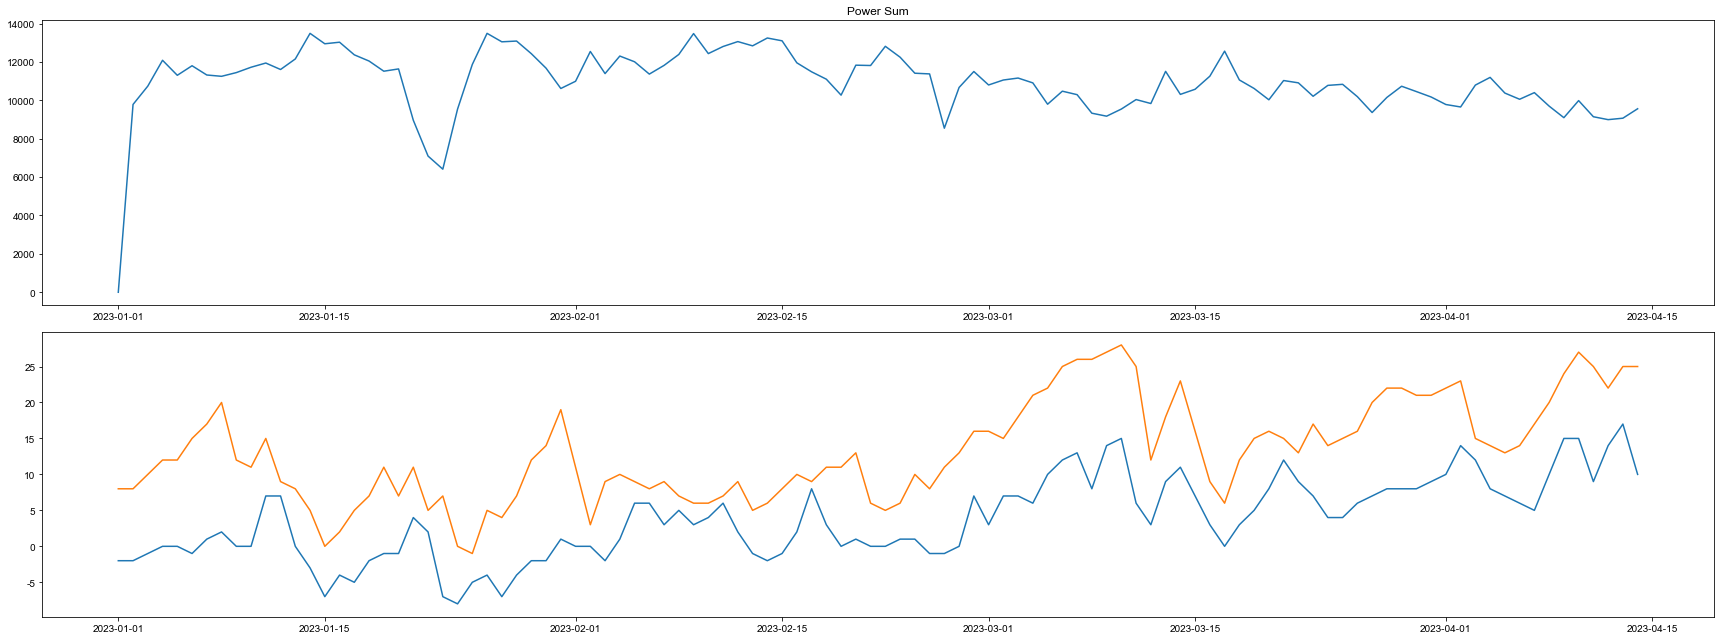

In [380]:
df_city1 = df_city_label[df_city_label['id_encode']==197]
df_city1 = df_city1[df_city1['ds']>20221231]
fig, axes = plt.subplots(2, 1, figsize=(24, 9))

axes[0].plot(df_city1['time'], df_city1['power_sum'])
axes[0].set_title('Power Sum')

axes[1].plot(df_city1['time'], df_city1['temp_min'])
axes[1].plot(df_city1['time'], df_city1['temp_max'])
plt.tight_layout()
plt.show();

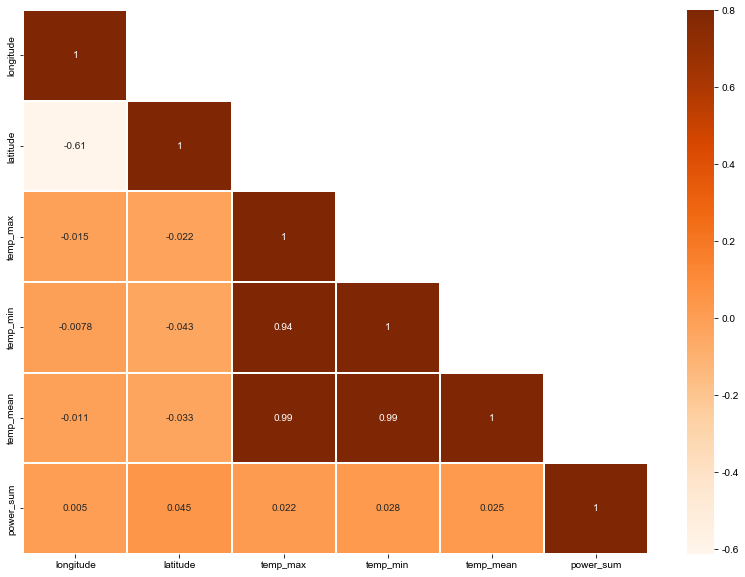

In [369]:
cols = ['longitude', 'latitude', 'temp_max', 'temp_min', 'temp_mean', 'power_sum']
corr_plot(df_city_label, cols)

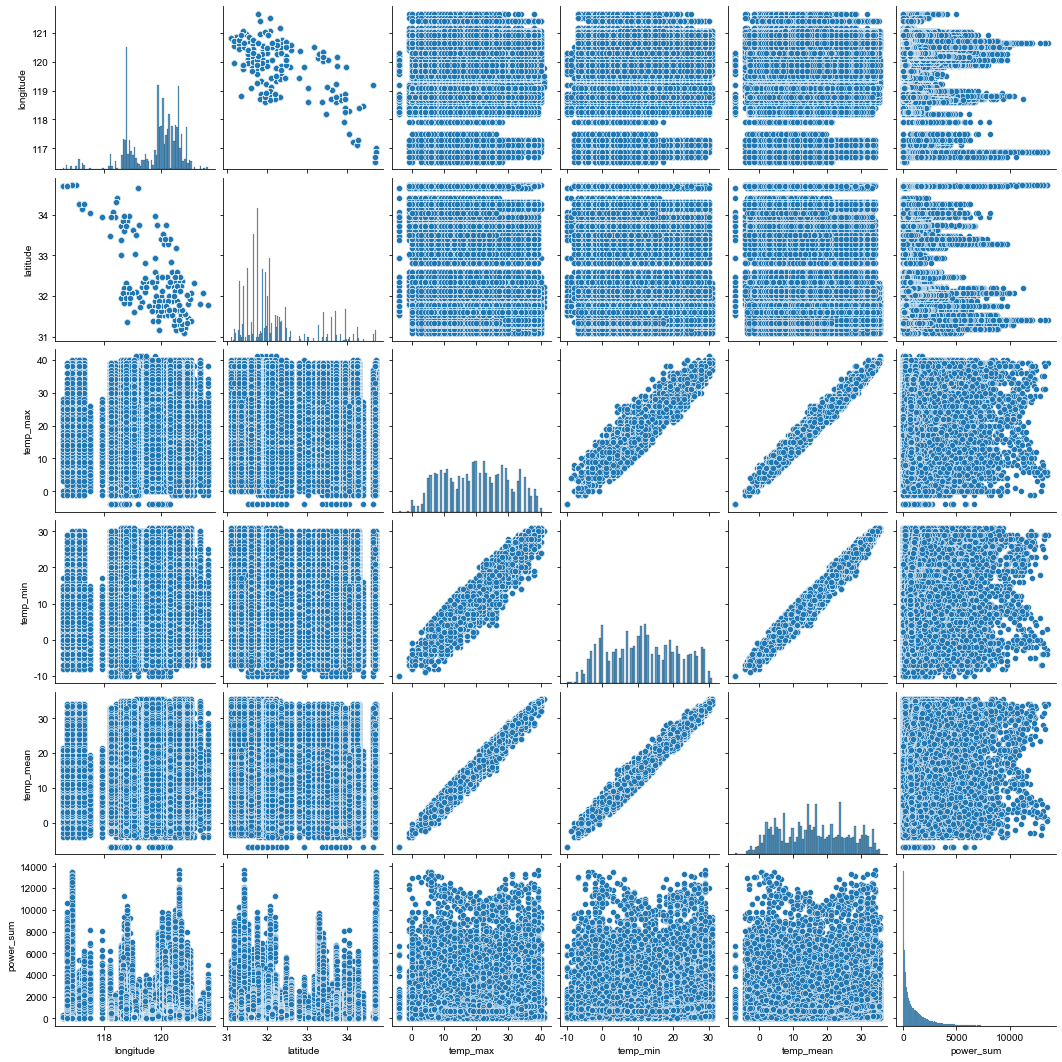

In [370]:
sns.pairplot(df_city_label[cols])

## 站点运营数据分析

In [225]:
df_his_tmp = df_his_day.merge(df_power_day, on=['id_encode','ds'],how='left')
df_his_tmp = df_his_tmp[df_his_tmp['ds']<20230415]
df_his_tmp['time'] = pd.to_datetime(df_his_tmp['ds'], format='%Y%m%d')
df_his_tmp['f3_mean'] = df_his_tmp['f3_mean'].fillna(0)

df_his_tmp['f2/f1'] = df_his_tmp['f2_mean'] / (df_his_tmp['f1_mean'] + 0.01)
df_his_tmp['f3/f1'] = df_his_tmp['f3_mean'] / (df_his_tmp['f1_mean'] + 0.01)
# for col in ['f1_mean', 'f2_mean', 'f3_mean']:
#     df_his_tmp[f'{col}_diff'] = df_his_tmp.groupby('id_encode')[col].transform(lambda x: x - x.shift(-1))
df_his_tmp

id_encode        ds  ele_price_mean  ser_price_mean  \
0               0  20220415            0.64            0.95   
1               0  20220416            0.64            0.95   
2               0  20220417            0.64            0.95   
3               0  20220418            0.64            0.95   
4               0  20220419            0.64            0.95   
...           ...       ...             ...             ...   
152532        499  20230410            0.00            0.51   
152533        499  20230411            0.00            0.51   
152534        499  20230412            0.00            0.51   
152535        499  20230413            0.00            0.51   
152536        499  20230414            0.00            0.51   

        after_ser_price_mean  total_price_mean  f1_mean  f2_mean  f3_mean  \
0                       0.31              1.59      0.0      0.0      1.0   
1                       0.31              1.59      0.0      0.0      1.0   
2                       0.31              1.59      0.0      0.0      1.0   
3                       0.31              1.59      0.0      0.0      1.0   
4                       0.31              1.59      0.0      0.0      1.0   
...                      ...               ...      ...      ...      ...   
152532                  0.51              0.51      3.0   1240.0      0.0   
152533                  0.51              0.51      3.0   1240.0      0.0   
152534                  0.51              0.51      3.0   1240.0      0.0   
152535                  0.51              0.51      3.0   1240.0      0.0   
152536                  0.51              0.51      3.0   1240.0      0.0   

        all_price        折扣  power_sum   power_std       time       f2/f1  \
0            0.95  0.322917  2288.2240  228.522181 2022-04-15    0.000000   
1            0.95  0.322917  2398.5730  243.331827 2022-04-16    0.000000   
2            0.95  0.322917  2313.0330  238.443485 2022-04-17    0.000000   
3            0.95  0.322917  2095.3259  184.758623 2022-04-18    0.000000   
4            0.95  0.322917  1834.3590  168.236393 2022-04-19    0.000000   
...           ...       ...        ...         ...        ...         ...   
152532       0.51  0.980769   653.9099   64.726654 2023-04-10  411.960133   
152533       0.51  0.980769   663.0800   63.276022 2023-04-11  411.960133   
152534       0.51  0.980769   678.3201   64.721746 2023-04-12  411.960133   
152535       0.51  0.980769   704.5300   68.952149 2023-04-13  411.960133   
152536       0.51  0.980769   658.4100   63.264448 2023-04-14  411.960133   

        f3/f1  
0       100.0  
1       100.0  
2       100.0  
3       100.0  
4       100.0  
...       ...  
152532    0.0  
152533    0.0  
152534    0.0  
152535    0.0  
152536    0.0  

[149044 rows x 16 columns]

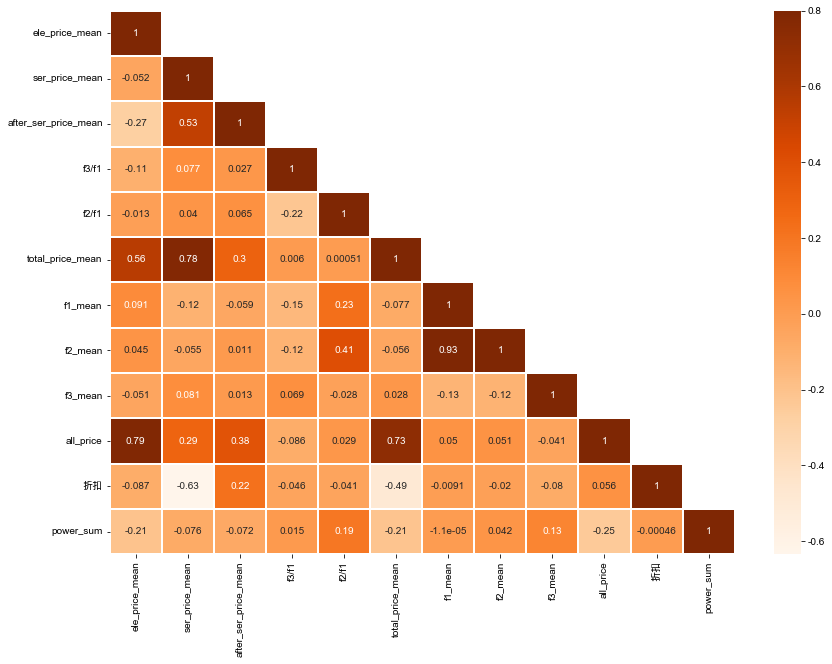

In [226]:
cols = ['ele_price_mean', 'ser_price_mean', 'after_ser_price_mean','f3/f1', 'f2/f1',
       'total_price_mean','f1_mean', 'f2_mean','f3_mean', 'all_price', '折扣', 'power_sum']#,'f1_mean_diff','f2_mean_diff', 'f3_mean_diff'
corr_plot(df_his_tmp, cols)

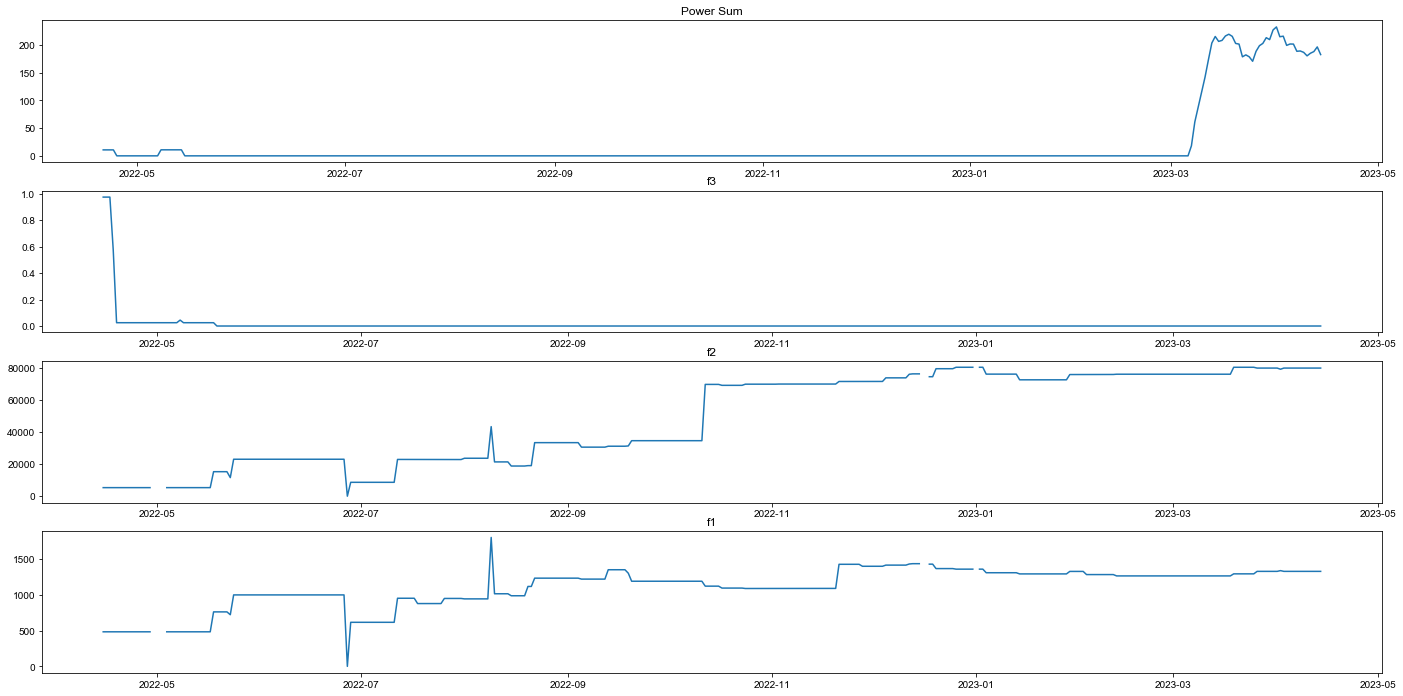

In [349]:
# df_tmp1 = df_tmp[df_tmp['ds']>20220415]
# df_tmp1 = df_tmp[(df_tmp['ds']> 20221001)&(df_tmp['ds'] < 20221030)]#[['ds', 'power_sum']]
df_tmp = df_his_tmp[df_his_tmp['id_encode']==290]
fig, axes = plt.subplots(4, 1, figsize=(24, 12))

axes[0].plot(df_tmp['time'], df_tmp['power_sum'].rolling(7).mean())
axes[0].set_title('Power Sum')

axes[1].plot(df_tmp['time'], df_tmp['f3_mean'])
axes[1].set_title('f3')

axes[2].plot(df_tmp['time'], df_tmp['f2_mean'])
axes[2].set_title('f2')

axes[3].plot(df_tmp['time'], df_tmp['f2/f1'])
axes[3].set_title('f1');

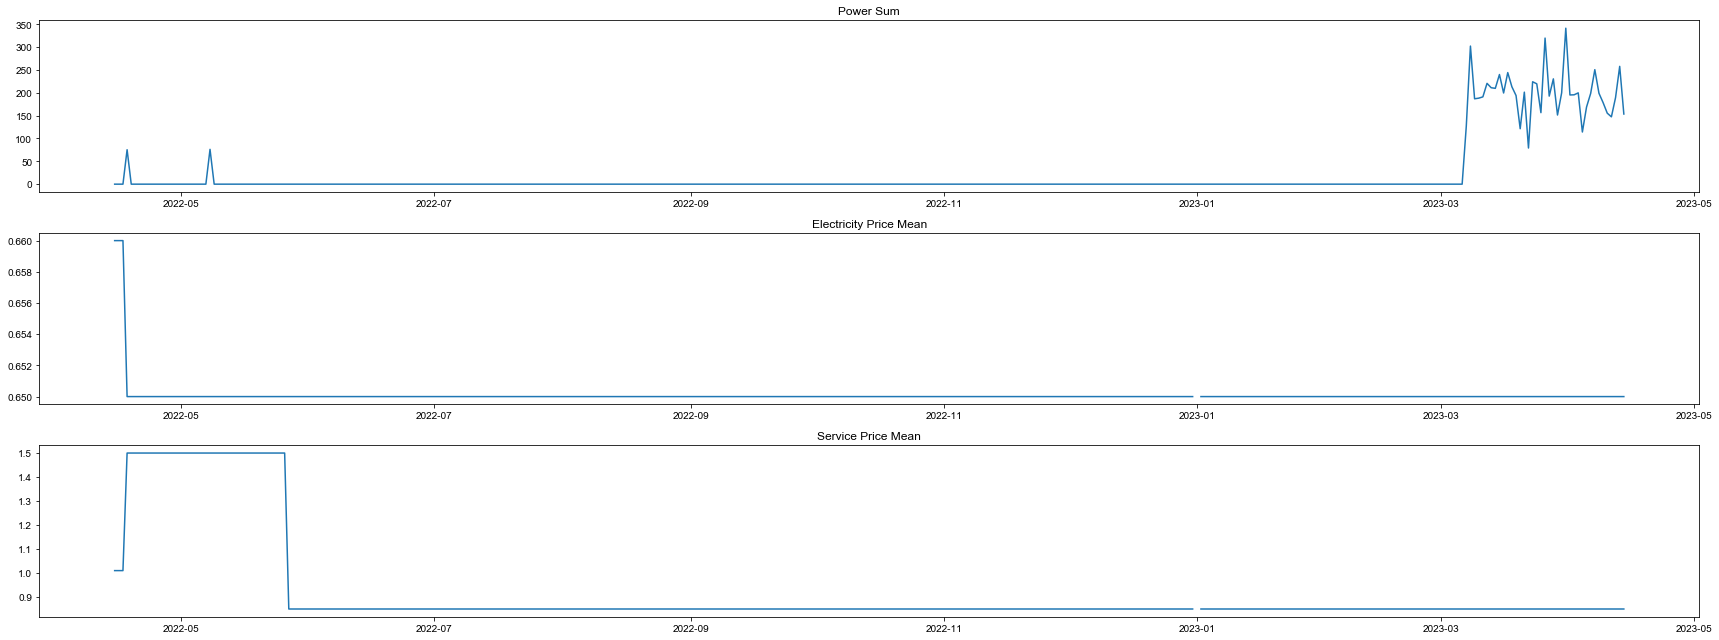

In [350]:


fig, axes = plt.subplots(3, 1, figsize=(24, 9))

axes[0].plot(df_tmp['time'], df_tmp['power_sum'])
axes[0].set_title('Power Sum')

axes[1].plot(df_tmp['time'], df_tmp['ele_price_mean'])
axes[1].set_title('Electricity Price Mean')

axes[2].plot(df_tmp['time'], df_tmp['ser_price_mean'])
axes[2].set_title('Service Price Mean')

plt.tight_layout()

plt.show();


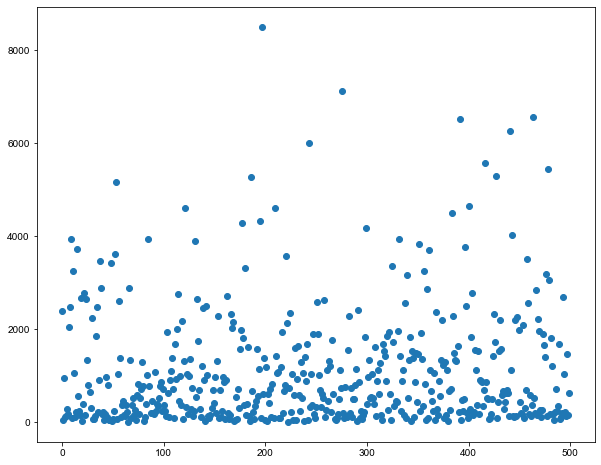

In [354]:
df_tmp = df_train.groupby(['id_encode']).agg({'power_sum': ['mean'], 'all_price': ['mean', 'std']}).reset_index()
df_tmp.columns = [x[0] if x[1] == '' else f'{x[0]}_{x[1]}' for x in df_tmp.columns]

plt.figure(figsize=[10, 8])
# plt.scatter(df_train['all_price'], df_train['power_sum']);
# 价格高
plt.scatter(df_tmp['id_encode'], df_tmp['power_sum_mean']);

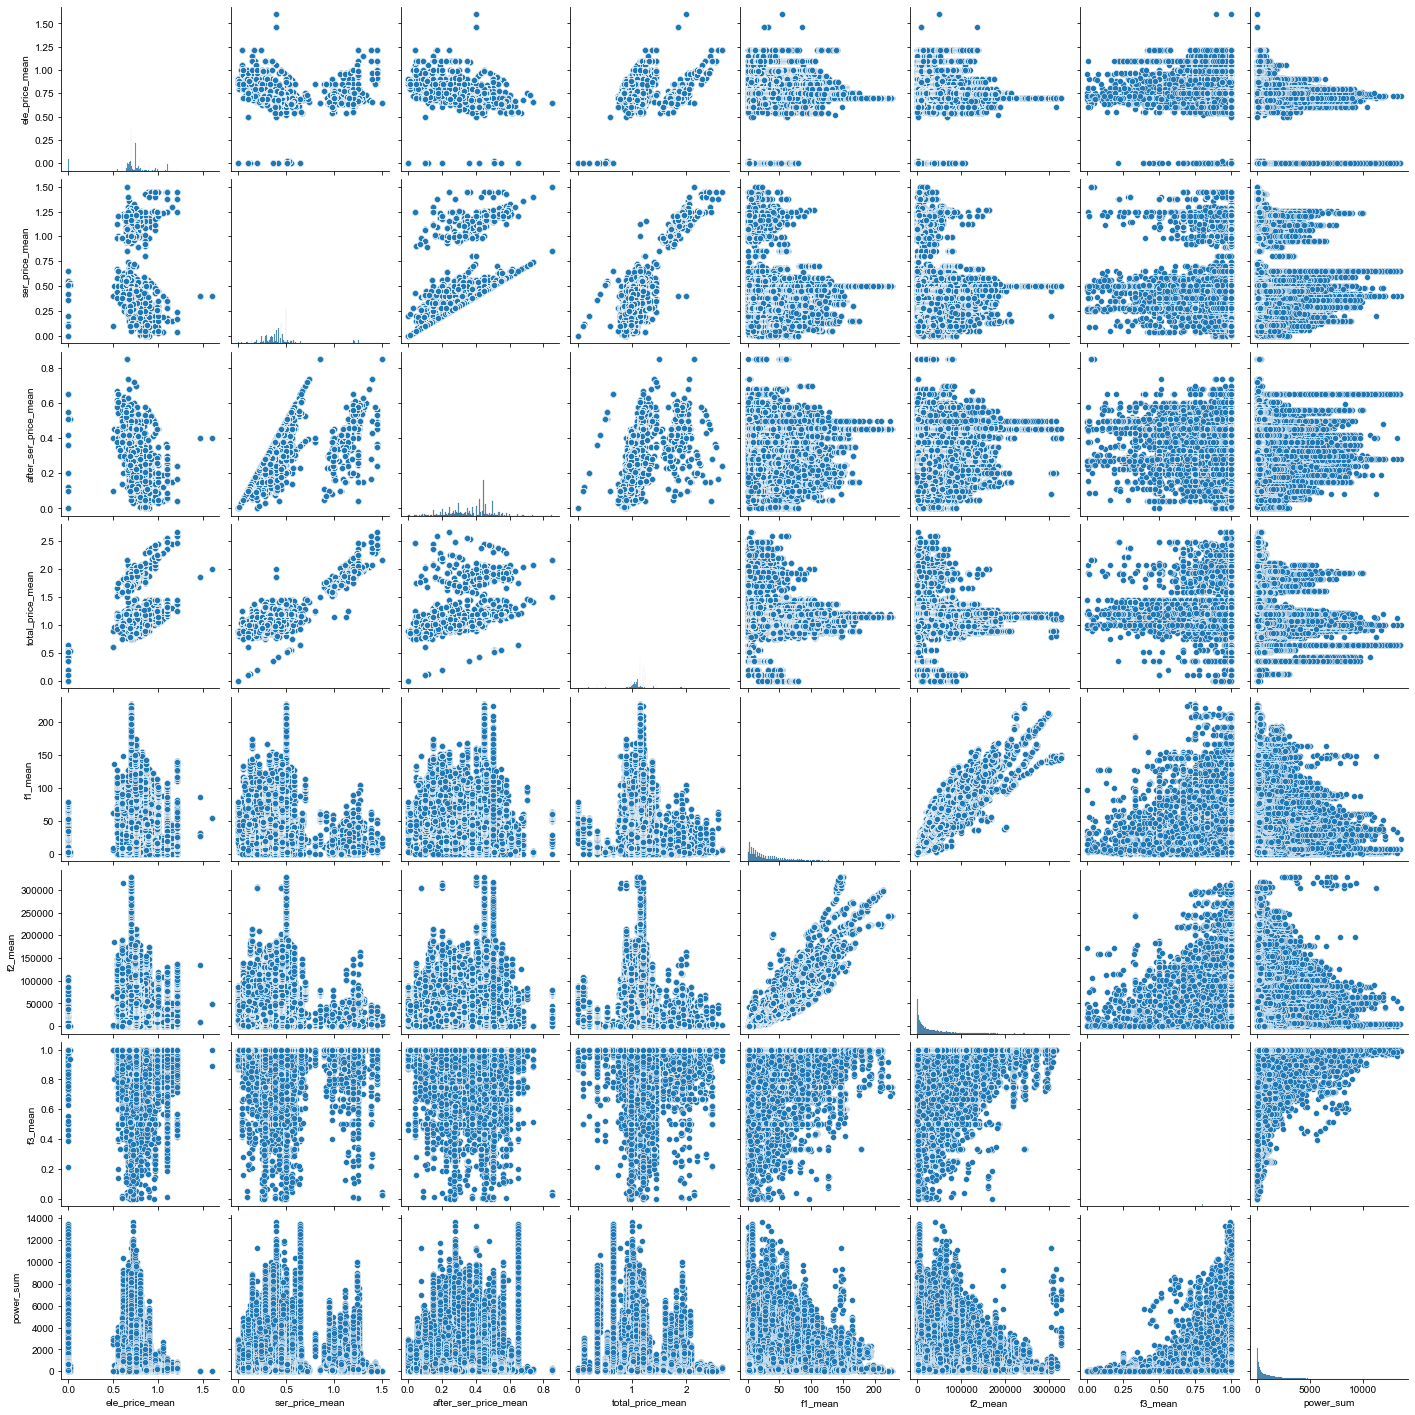

In [142]:
sns.pairplot(df_train[cols])

## 电桩分析

In [229]:
df_stub.columns

Index(['id_encode', 'parking_free', 'flag', 'h3', 'ac_equipment_kw',
       'dc_equipment_kw'],
      dtype='object')

In [230]:
df_stub['parking_free'].value_counts()

2.0    232
1.0    209
0.0     58
4.0      1
Name: parking_free, dtype: int64

In [253]:
df_tmp = df_train.groupby(['id_encode']).agg({'power_sum': ['mean', 'std']}).reset_index()
df_tmp.columns = [x[0] if x[1] == '' else f'{x[0]}_{x[1]}' for x in df_tmp.columns]
df_stub_1 = df_tmp.merge(df_stub, on='id_encode',how='left')
df_stub_1

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
0            0     2382.431650     328.470884           1.0    A   
1            1       47.271729      40.739497           2.0    B   
2            2      949.541737     380.624267           1.0    A   
3            3      112.213377      59.319284           1.0    B   
4            4      120.943969     151.525299           1.0    A   
..         ...             ...            ...           ...  ...   
495        495      213.535889      70.047792           0.0    A   
496        496      139.898462      90.999796           0.0    A   
497        497     1455.265132     454.167523           2.0    A   
498        498      143.683034      56.522598           2.0    B   
499        499      615.055265     299.623376           1.0    A   

                  h3  ac_equipment_kw  dc_equipment_kw  
0    85309ea7fffffff              0.0           1440.0  
1    8530916bfffffff             14.0             60.0  
2    853086a3fffffff              0.0            720.0  
3    85309cb3fffffff              0.0             60.0  
4    85308607fffffff              0.0            720.0  
..               ...              ...              ...  
495  85309c4ffffffff             14.0             80.0  
496  85309897fffffff              0.0            720.0  
497  85309c6ffffffff              0.0            720.0  
498  8530916bfffffff             14.0             60.0  
499  85309ca3fffffff              0.0            540.0  

[500 rows x 8 columns]

### 标签范围分析

In [295]:
df_stub_1[df_stub_1['power_sum_mean']>5000]

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
53          53     5168.947709    1282.873791           2.0    A   
186        186     5285.203324    1207.471272           1.0    A   
197        197     8511.535813    3757.173275           1.0    A   
243        243     6012.130099    1688.929886           2.0    A   
275        275     7133.564573     997.763399           1.0    A   
391        391     6523.882383    2764.231962           2.0    A   
416        416     5568.662221    1496.185601           1.0    A   
427        427     5294.376817     844.600926           1.0    A   
441        441     6256.967522    1102.301935           1.0    A   
463        463     6571.085340    1135.464073           2.0    B   
478        478     5457.720478    1303.195396           2.0    A   

                  h3  ac_equipment_kw  dc_equipment_kw  
53   853098d7fffffff              0.0           2400.0  
186  8530839bfffffff              0.0           1440.0  
197  8530b0bbfffffff              0.0           2400.0  
243  853098c7fffffff              0.0           1980.0  
275  8530b08ffffffff              0.0           2400.0  
391  85309813fffffff              0.0           2640.0  
416  85308383fffffff              0.0           1560.0  
427  85309c4ffffffff              0.0           1740.0  
441  85309c7bfffffff              0.0           2280.0  
463  8530980bfffffff             28.0           1200.0  
478  853098c7fffffff              0.0           2400.0

In [357]:
df_stub_1[df_stub_1['h3']=='8530b0bbfffffff']

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
197        197     8511.535813    3757.173275           1.0    A   

                  h3  ac_equipment_kw  dc_equipment_kw  
197  8530b0bbfffffff              0.0           2400.0

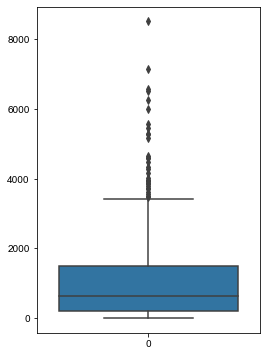

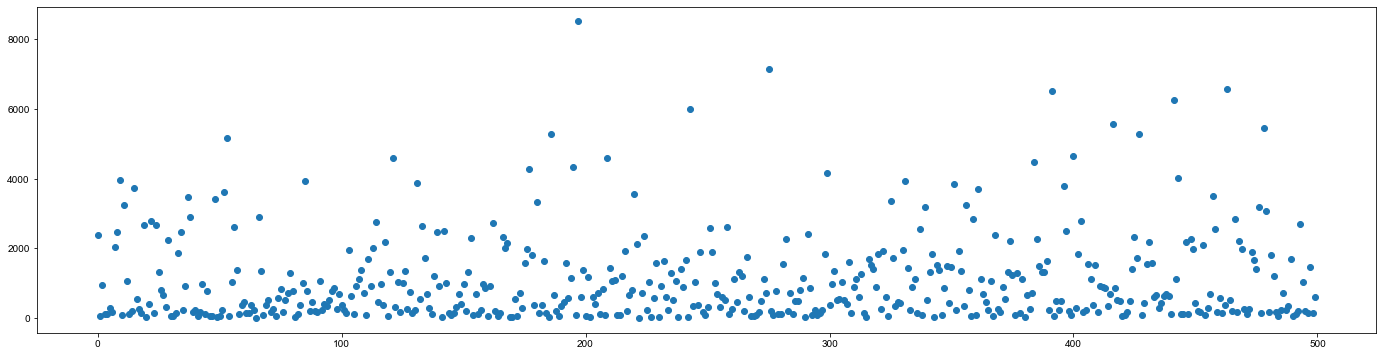

In [290]:
plt.figure(figsize=[4, 6])
sns.boxplot(df_stub_1['power_sum_mean']);
plt.figure(figsize=[24, 6])
plt.scatter(df_stub_1['id_encode'], df_stub_1['power_sum_mean']);

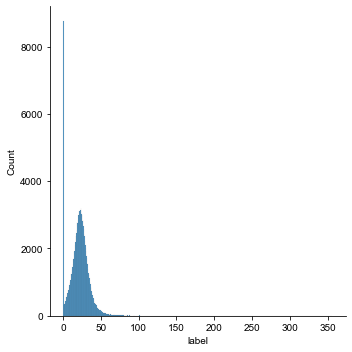

In [313]:
sns.displot(df_train['label']);

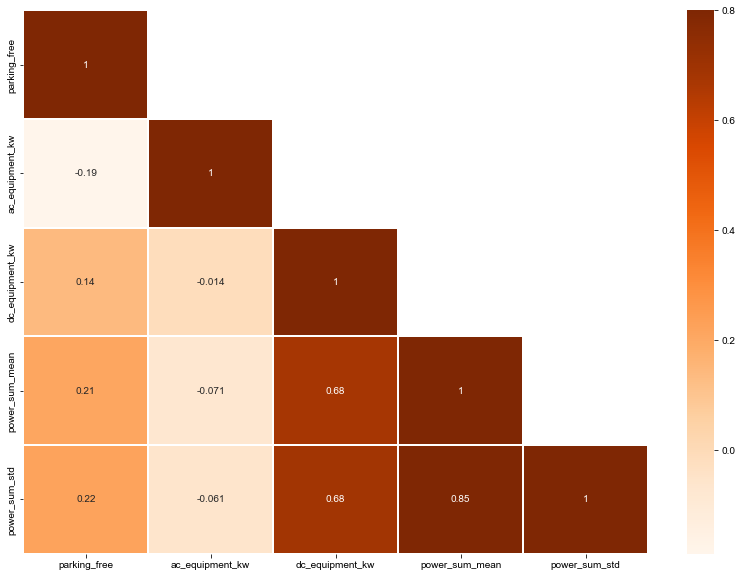

In [341]:
cols = ['parking_free',  'ac_equipment_kw', 'dc_equipment_kw', 'power_sum_mean', 'power_sum_std']
corr_plot(df_stub_1, cols);

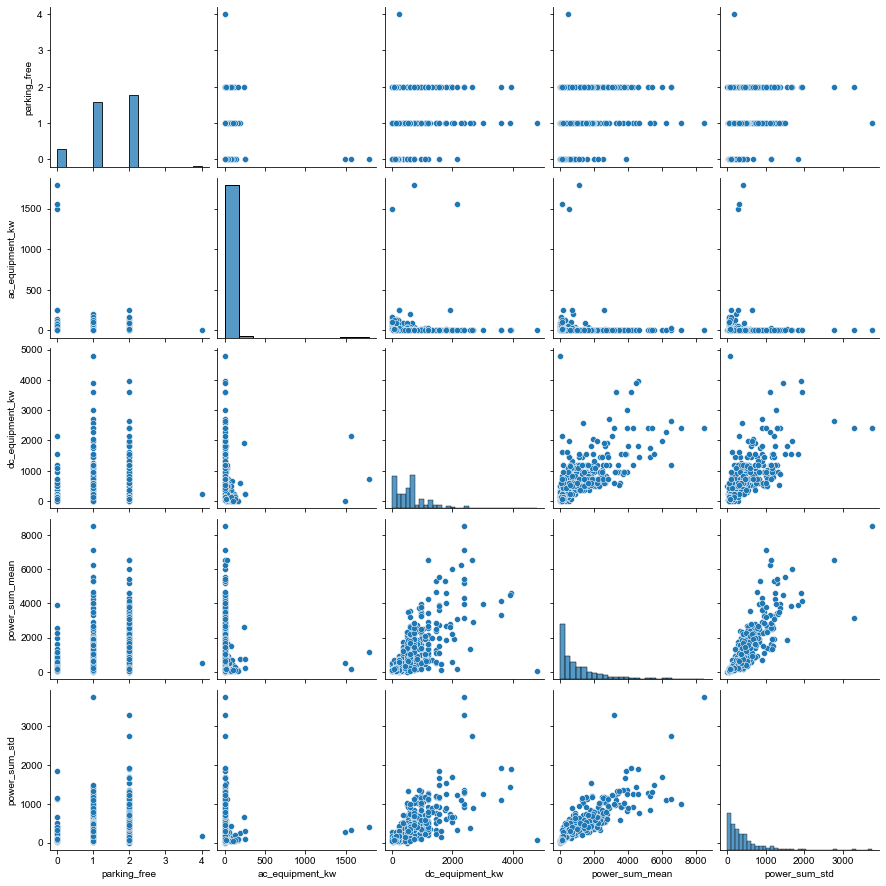

In [344]:
sns.pairplot(df_stub_1[cols]);

In [346]:
# 通常而言，直流桩功率越大，平均充电量越大，290是特殊情况
df_stub_1[df_stub_1['dc_equipment_kw']>3000]

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
121        121     4601.849567    1906.854101           2.0    A   
180        180     3326.589048    1109.752016           1.0    A   
290        290       21.972692      64.572390           1.0    A   
299        299     4167.532985    1934.559070           2.0    A   
384        384     4490.938473    1446.557901           1.0    A   

                  h3  ac_equipment_kw  dc_equipment_kw  
121  8530981bfffffff              0.0           3960.0  
180  85308607fffffff              0.0           3600.0  
290  85309d57fffffff              0.0           4800.0  
299  85309813fffffff              0.0           3600.0  
384  85309c7bfffffff              0.0           3900.0

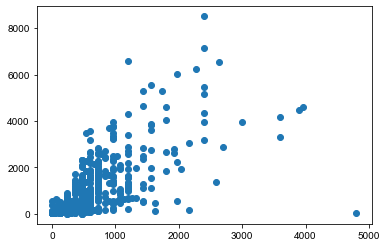

In [167]:
col = 'dc_equipment_kw'
df_tmp = df_train.groupby(['id_encode']).agg({'power_sum': ['mean'], col: ['mean', 'std']}).reset_index()
df_tmp.columns = [x[0] if x[1] == '' else f'{x[0]}_{x[1]}' for x in df_tmp.columns]
df_tmp
# plt.figure(figsize=[10, 10])
# # plt.scatter(df_train['all_price'], df_train['power_sum']);
# # 价格高
plt.scatter(df_tmp[f'{col}_mean'], df_tmp['power_sum_mean']);

## 0值分析

In [340]:
df_stub_1[df_stub_1['power_sum_mean']<20]

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
20          20       18.494771      54.125301           2.0    B   
65          65        6.466862      30.949351           2.0    B   
81          81       16.716552      72.498076           2.0    B   
185        185       17.885304      24.769181           0.0    A   
202        202       19.535791      39.602566           0.0    A   
222        222        0.000000       0.000000           2.0    B   
238        238       14.960788      42.184930           1.0    A   

                  h3  ac_equipment_kw  dc_equipment_kw  
20   85309dcbfffffff              0.0            120.0  
65   85309c77fffffff              0.0            240.0  
81   85309c77fffffff              0.0            240.0  
185  8530910bfffffff              0.0            480.0  
202  85309eb7fffffff              0.0            240.0  
222  85309c2bfffffff              0.0            480.0  
238  85309eb7fffffff              0.0            480.0

In [131]:
df_power_0 = df_power_day[df_power_day['power_sum']==0].groupby('id_encode').count().sort_index()
df_power_0['power_sum'].mean()
df_power_0

20.40973630831643

ds  power_sum  power_std
id_encode                          
0           1          1          0
1          61         61         60
2          14         14         13
3          13         13         12
4          31         31         30
...        ..        ...        ...
495         1          1          0
496         6          6          5
497         1          1          0
498         1          1          0
499        21         21         20

[493 rows x 3 columns]

In [328]:
# df_power[df_power['id_encode'] == 65]

In [347]:

# # df_tmp2 = df[(df['id_encode'] == 0)&(df['ds'] == 20220422)] #[['time', 'power', 'power_1week']]
# plt.figure(figsize=[24, 6])
# plt.plot(df_tmp['time'], df_tmp['power_sum']);
# # plt.plot(df_tmp2['hour'], df_tmp2['power_1week']);

In [ ]:
# id499突降是因为f3变成了空
df_tmp1[df_tmp1['power_sum']<5][['ds', 'power_sum', 'f3_mean']]
# id20: f3全为空，但后期power开始出现

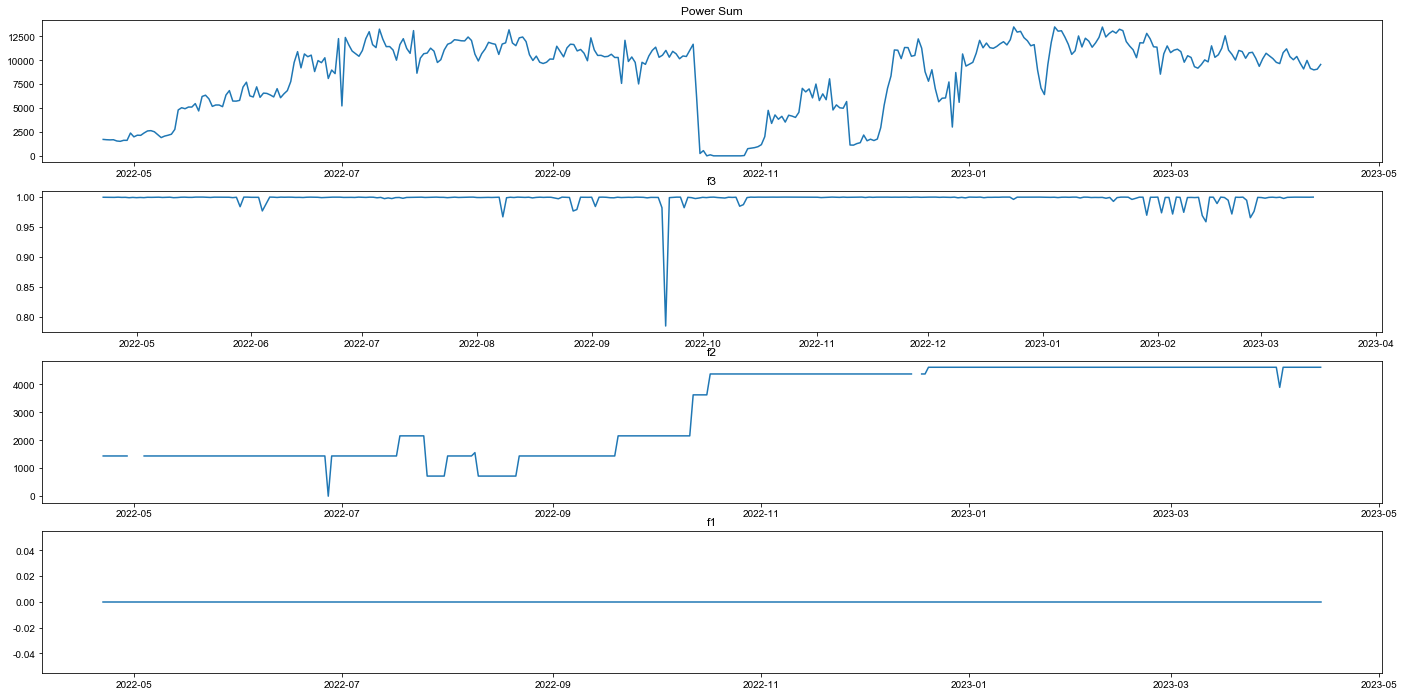

In [355]:
df_tmp = df_train[(df_train['id_encode'] == 197)]
# 某段突降分析
df_tmp1 = df_tmp[df_tmp['ds']>20220415]
# df_tmp1 = df_tmp[(df_tmp['ds']> 20221001)&(df_tmp['ds'] < 20221030)]#[['ds', 'power_sum']]
fig, axes = plt.subplots(4, 1, figsize=(24, 12))

axes[0].plot(df_tmp['time'], df_tmp['power_sum'])#.rolling(7).mean()
axes[0].set_title('Power Sum')

axes[1].plot(df_tmp['time'], df_tmp['f3_mean'])
axes[1].set_title('f3')

axes[2].plot(df_tmp['time'], df_tmp['f2_mean'])
axes[2].set_title('f2');

axes[3].plot(df_tmp['time'], df_tmp['ac_equipment_kw'])
axes[3].set_title('f1');

## 标签时序分析

In [279]:
h3_id1 = df_stub_1[df_stub_1['h3'] == '85309c4ffffffff']['id_encode'].tolist()
# 有些电站会有相似的变化趋势
df_stub_1['h3'].value_counts()

85309c4ffffffff    24
85309c7bfffffff    21
85309eb7fffffff    17
8530981bfffffff    16
853098d7fffffff    14
                   ..
85309137fffffff     1
85309d4ffffffff     1
85309c03fffffff     1
8530b3a7fffffff     1
85309ca3fffffff     1
Name: h3, Length: 141, dtype: int64

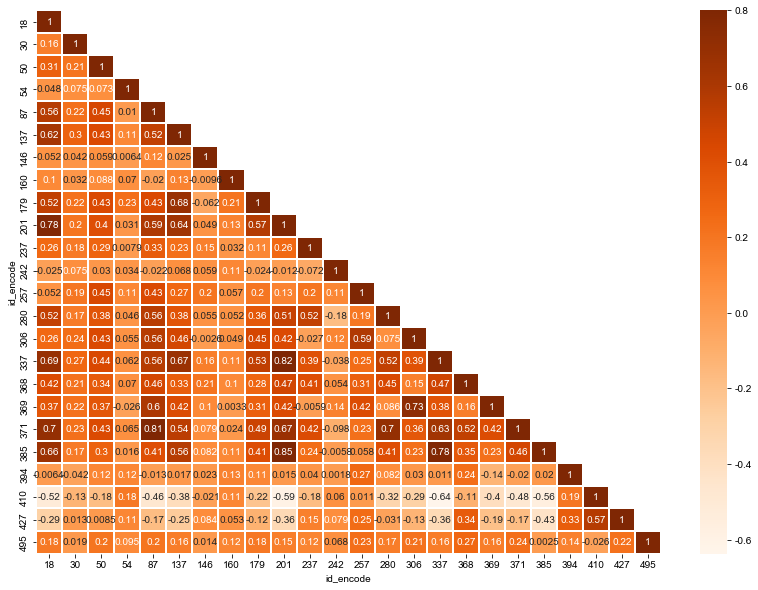

In [280]:
df_power_id = df_train[['id_encode', 'ds','power_sum']].pivot_table(values='power_sum', index='ds', columns='id_encode').fillna(0).astype(int).reset_index()
cols = h3_id1#df_power_id.columns[200:230]
corr_plot(df_power_id, cols);

In [255]:
df_stub_1[df_stub_1['id_encode'].isin([11,17,18])]

id_encode  power_sum_mean  power_sum_std  parking_free flag  \
11         11     3244.911134    1210.817136           2.0    B   
17         17      243.976616     127.539363           1.0    A   
18         18      147.566741      82.871393           2.0    A   

                 h3  ac_equipment_kw  dc_equipment_kw  
11  85309857fffffff              0.0            960.0  
17  85309cdbfffffff              0.0            360.0  
18  85309c4ffffffff             42.0            300.0

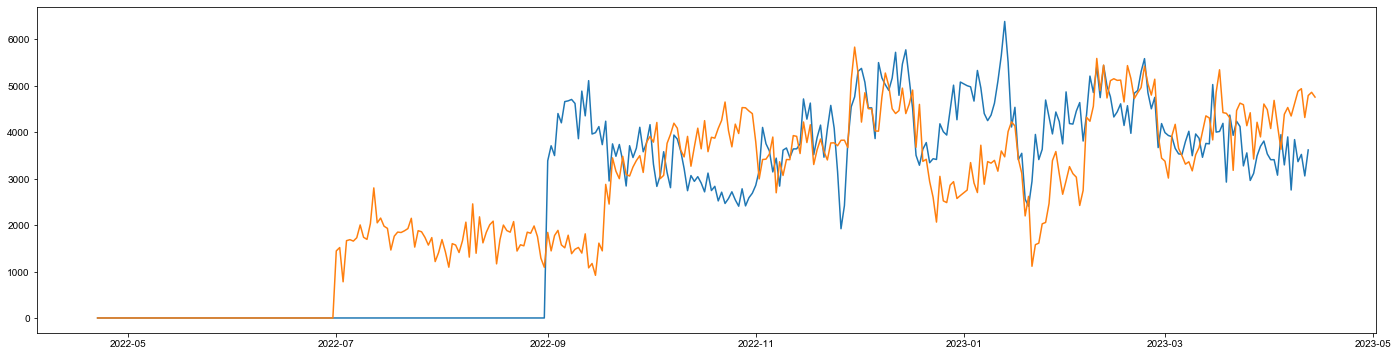

In [271]:
# plt.figure(figsize=[24, 6])
# plt.plot(pd.to_datetime(df_power_id['ds'], format='%Y%m%d'), df_power_id[9].shift(-2));
# plt.plot(pd.to_datetime(df_power_id['ds'], format='%Y%m%d'), df_power_id[11]);

In [409]:
# df_power_mean[df_power_mean['power'] > 200]
list(df_power_mean.sort_values('power').tail(10)['id_encode'])
list(df_power_mean.sort_values('power').head(10)['id_encode'])

list(df_power_mean.sort_values('power').iloc[130:140]['id_encode'])

[186, 427, 478, 416, 243, 441, 391, 463, 275, 197]

[222, 65, 238, 81, 202, 20, 185, 49, 290, 380]

[276, 87, 451, 217, 151, 398, 485, 188, 14, 495]

### 小城市节假日下降，大城市节假日上升

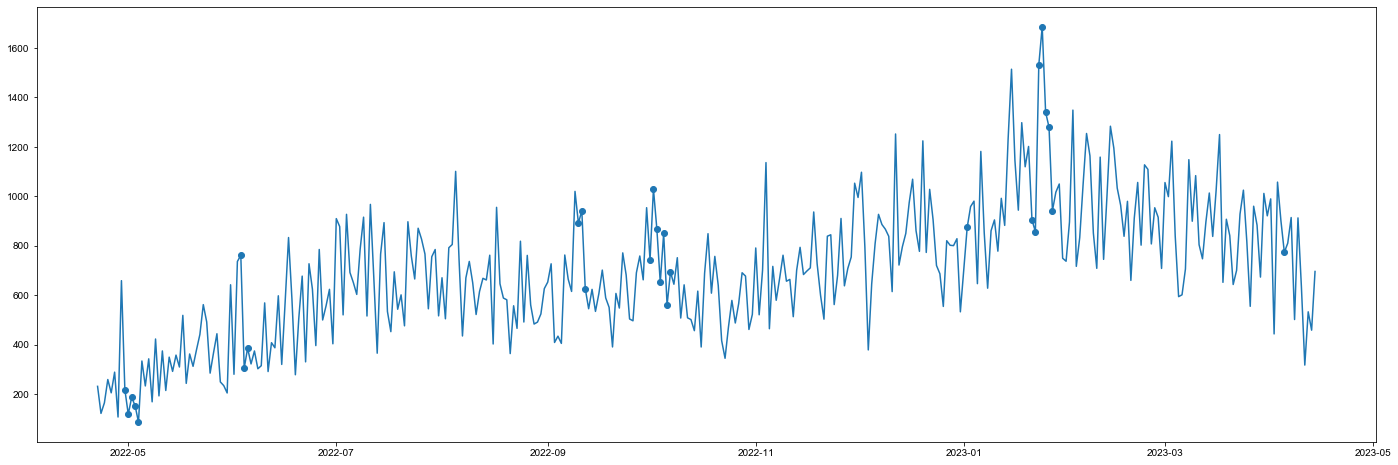

In [417]:
# 小城市节假日下降，大城市节假日上升
plt.figure(figsize=[24, 8])
for id in [456]:#, 441, 391, 463, 275, 197
    df_tmp = df_train[(df_train['id_encode'] == id)]
    df_tmp1 = df_train[(df_train['id_encode'] == id)&((df_train['is_holiday'] == 1))]
    plt.plot(df_tmp['time'], df_tmp['power_sum']);
    plt.scatter(df_tmp1['time'], df_tmp1['power_sum']);
plt.show();

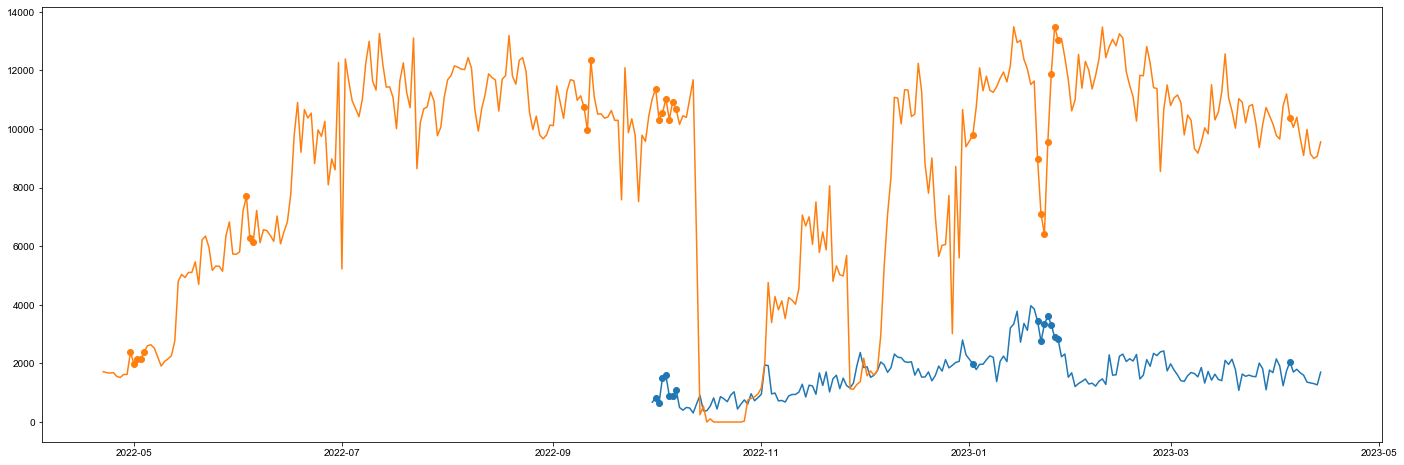

In [13]:

# df_tmp2 = df[(df['id_encode'] == 0)&(df['ds'] == 20220422)] #[['time', 'power', 'power_1week']]
plt.figure(figsize=[24, 8])
for id in [ 474, 197]:
    df_tmp = df_train[(df_train['id_encode'] == id)]
    df_tmp1 = df_train[(df_train['id_encode'] == id)&((df_train['is_holiday'] == 1))]
    plt.plot(df_tmp['time'], df_tmp['power_sum']);
    plt.scatter(df_tmp1['time'], df_tmp1['power_sum']);
plt.show();

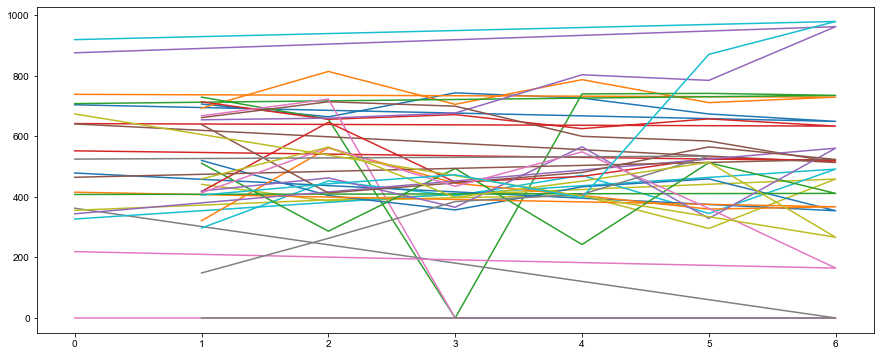

In [98]:
plt.figure(figsize=[15, 6])
for i in range(20,40):
    plt.plot(df_tmp[df_tmp['weeks']==i]['day_of_week'], df_tmp[df_tmp['weeks']==i]['power_sum']);
plt.show();

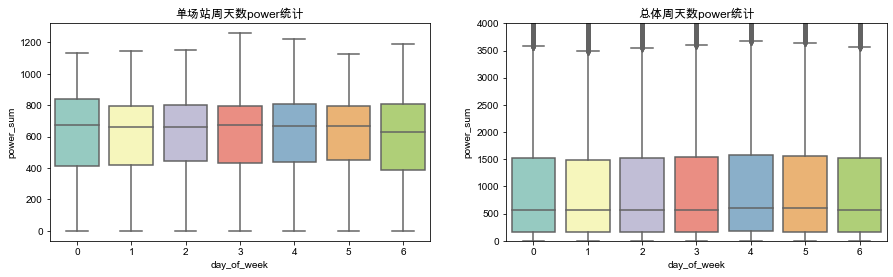

In [99]:
# df.groupby('day_of_week')['power_sum'].mean()
fig, axes = plt.subplots(1, 2, figsize=[15,4])#,sharey=True
sns.boxplot(x='day_of_week', y='power_sum', data=df_tmp, palette='Set3',ax=axes[0]);
axes[0].set_title('单场站周天数power统计')
sns.boxplot(x='day_of_week', y='power_sum', data=df_train, palette='Set3',ax=axes[1]);
axes[1].set_title('总体周天数power统计');
axes[1].set_ylim([0,4000]);
# 比较平稳，周末和周内相比没有明显起伏

In [ ]:
cols1 = ['power_roll7_7ago_std',
 'f3_mean',
 'power_roll14_14ago_std',
 'power_roll30_30ago_std',
 'power_roll21_21ago_std',
 'power_4week',
 'power_3week',
 'power_2week',
 'power_1week',
 'power_sum_std_2week',
 'power_roll7_7ago',
 'power_roll30_30ago',
 'power_roll21_21ago',
 'f2_mean',
 'power_roll14_14ago',
 'power_sum']
corr_plot(df_train, cols1)

## sub分析

In [96]:
df1 = pd.read_csv('../data/interim/oof_20231015_2317_oofrmse261.2.csv')
df2 = pd.read_csv('../data/interim/oof_20231013_16:36_oofrmse277.1.csv')
df1

Unnamed: 0  id_encode        ds  power_sum         pred
0                7          0  20220422  1757.1749  2274.924536
1                8          0  20220423  2115.7820  2097.573246
2                9          0  20220424  2214.8261  2033.320433
3               10          0  20220425  2468.1490  1810.242110
4               11          0  20220426  2297.6681  1999.948422
...            ...        ...       ...        ...          ...
145073      185988        499  20230410   653.9099   723.210865
145074      185989        499  20230411   663.0800   628.561505
145075      185990        499  20230412   678.3201   658.115244
145076      185991        499  20230413   704.5300   660.967977
145077      185992        499  20230414   658.4100   732.674421

[145078 rows x 5 columns]

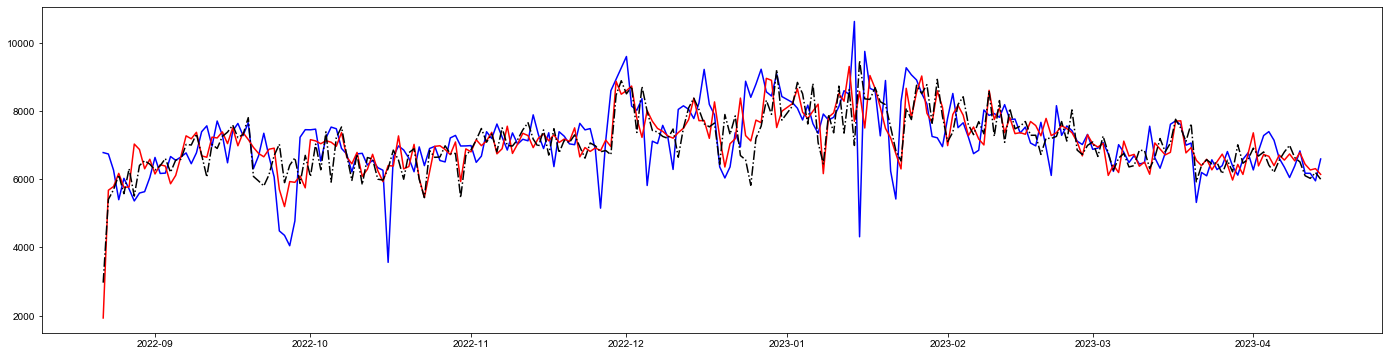

In [296]:
nid = 275
df1['time'] = pd.to_datetime(df1['ds'], format='%Y%m%d')
df2['time'] = pd.to_datetime(df2['ds'], format='%Y%m%d')
t = 20220801
df_tmp1 = df1[(df1['id_encode']==nid)&(df1['ds']>t)]
df_tmp2 = df2[(df2['id_encode']==nid)&(df1['ds']>t)]
plt.figure(figsize=[24, 6])

plt.plot(df_tmp1['time'], df_tmp1['power_sum'],c='b');
plt.plot(df_tmp1['time'], df_tmp1['pred'],c='r');
plt.plot(df_tmp2['time'], df_tmp2['pred'], c='k', linestyle='-.',);

In [37]:
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
np.sqrt(mean_squared_error(df_tmp1['power_sum'], df_tmp1['pred']))
np.sqrt(mean_squared_error(df_tmp2['power_sum'], df_tmp2['pred']))

101.13016807465513

99.2574264160806